In [1]:
# CNN with bound box
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNBB(nn.Module):
    def __init__(self, number_classes):
        super(CNNBB, self).__init__()
        self.number_classes = number_classes
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=11, stride=1, padding='same')
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=11, stride=1, padding='same')
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=11, stride=1, padding='same')
        self.conv4 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=11, stride=1, padding='same')
        self.conv5 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=11, stride=1, padding='same')
        self.conv6 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=11, stride=1, padding='same')
        self.conv7 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=11, stride=1, padding='same')
        self.conv8 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=11, stride=1, padding='same')

        self.pool1 = nn.AvgPool1d(kernel_size=2, stride=2)
        self.pool2 = nn.AvgPool1d(kernel_size=4, stride=4)
        self.fc1 = nn.Linear(8192, 2048)
        self.fc2 = nn.Linear(2048, 2048)
        self.predictions = nn.Linear(2048, number_classes+2)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = F.relu(self.conv3(x))
        x = self.pool1(x)
        x = F.relu(self.conv4(x))
        x = self.pool1(x)
        x = F.relu(self.conv5(x))
        x = self.pool1(x)
        x = F.relu(self.conv6(x))
        x = self.pool2(x)
        x = F.relu(self.conv7(x))
        x = self.pool2(x)
        x = F.relu(self.conv8(x))
        x = self.pool2(x)
        x = x.view(-1, 8192)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.predictions(x)
        return x
        # return x

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
updated_model = CNNBB(number_classes=9).to(device)
print(updated_model)

input = torch.randn(1, 131072).to(device)
output = updated_model(input)
print(output)
from torchsummary import summary

summary(updated_model, (1, 131072))

CNNBB(
  (conv1): Conv1d(1, 16, kernel_size=(11,), stride=(1,), padding=same)
  (conv2): Conv1d(16, 32, kernel_size=(11,), stride=(1,), padding=same)
  (conv3): Conv1d(32, 64, kernel_size=(11,), stride=(1,), padding=same)
  (conv4): Conv1d(64, 128, kernel_size=(11,), stride=(1,), padding=same)
  (conv5): Conv1d(128, 128, kernel_size=(11,), stride=(1,), padding=same)
  (conv6): Conv1d(128, 128, kernel_size=(11,), stride=(1,), padding=same)
  (conv7): Conv1d(128, 128, kernel_size=(11,), stride=(1,), padding=same)
  (conv8): Conv1d(128, 128, kernel_size=(11,), stride=(1,), padding=same)
  (pool1): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (pool2): AvgPool1d(kernel_size=(4,), stride=(4,), padding=(0,))
  (fc1): Linear(in_features=8192, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=2048, bias=True)
  (predictions): Linear(in_features=2048, out_features=11, bias=True)
)
tensor([[-0.0110, -0.0157,  0.0061, -0.0172,  0.0024, -0.0114, -0.0037, -0.01

In [3]:
import numpy as np
input_data = np.load('datasets/nodemcu-random-label-train/2020-02-17_11-22-32_917765_traces.npy', allow_pickle=True)
print(input_data[0].shape)
input_data_meta = np.load('datasets/nodemcu-random-label-train/2020-02-17_11-22-32_917765_meta.p', allow_pickle=True)
print(input_data_meta[0])

(131072,)
{'op': 'sha1', 'datatype': 'complex64', 'left_bound': 16626.0, 'right_bound': 25172.0}


In [4]:
from batch import get_batch
import os
batch_size = 20
epochs = 500
learning_rate = 0.001

optimizer = torch.optim.Adam(updated_model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
datasets_root = './datasets'
dataset_names = ['nodemcu-random-label-train']

model = updated_model.to(device)

def split_batch(batch):
    inputs = np.stack(batch[:, 0], axis=0)[:, :, None]
    targets = np.stack(batch[:, 1], axis=0)
    labels = np.stack(batch[:, 2], axis=0)
    inputs = np.squeeze(inputs, axis=2)
    return inputs, targets, labels

New Loss function
$$L(y, \hat{y}) = CrossEntropy(y[1,\dots,n_0], \hat{y}[1, \dots, n_0]) + \lambda_b 1_b[(w-\hat{w})^2 + (m - \hat{m})^2]$$

In [5]:
class CustomLoss(nn.Module):
    def __init__(self, lambda_b=100):
        super(CustomLoss, self).__init__()
        self.lambda_b = lambda_b
    
    def indicator(self, y_true_cls, y_pred_cls, n_0):
        correct = y_true_cls == y_pred_cls
        not_noise = y_true_cls != n_0 - 1
        return (correct & not_noise).float()
        
    # input tensor shape : [batch_size, n_b + 2]
    def forward(self, y_pred, y_true):
        n_0 = y_true.size(1) - 2
        y_hat_cls = y_pred[:, :n_0]
        y_true_cls = y_true[:, :n_0]
        y_hat_w = y_pred[:, -2]
        y_hat_m = y_pred[:, -1]
        y_true_w = y_true[:, -2]
        y_true_m = y_true[:, -1]
        
        y_true_cls = y_true_cls.argmax(dim=1)
        y_pred_cls = y_hat_cls.argmax(dim=1)
        
        ind = self.indicator(y_true_cls, y_pred_cls, n_0)
        loss_cls = F.cross_entropy(y_hat_cls, y_true_cls)
        return loss_cls + (self.lambda_b*ind*((y_true_w-y_hat_w)**2 + (y_true_m - y_hat_m)**2)).mean()
        
# y_pred = torch.randn(10, 11)
# y_true = torch.randn(10, 11)
# criterion = CustomLoss()
# print(criterion(y_pred, y_true))

In [ ]:
# load pretrained model
pretrained_dict= torch.load('./models/best_cnn-epoch-10.pt')
updated_model.load_state_dict(pretrained_dict, strict=False)
print("Pre-trained model loaded.")

batch_c = []  # Batch container
for dataset_name in dataset_names:
    dataset_path = os.path.join(datasets_root, dataset_name)
    dataset_files = list(os.listdir(dataset_path))
    for epoch in range(epochs):
        cnt = 0
        for i, dataset_file in enumerate(dataset_files):
            if '_traces.npy' in dataset_file:
                for batch in get_batch(dataset_path, dataset_file, batch_c, batch_size=batch_size, with_bound=True):
                    cnt += 1
                    input, target, label = split_batch(batch)
                    xs = torch.tensor(input).float().to(device)
                    ys = torch.tensor(label).float().to(device)
                    # print(ys, ys.shape)
                    # print(label, label.shape)
                    y_pred = model(xs)             
                    loss = criterion(y_pred, ys)
                    print(f'Epoch {epoch}, Batch {cnt}, Loss: {loss.item()}')

                    optimizer.zero_grad()
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
                    optimizer.step()
        # Save model
        if epoch % 50 == 0:
            torch.save(model.state_dict(), f'./models/CNNBB-epoch-{epoch}.pt')

For this experiment, we obtain an accuracy of 74.90%, and a precision and recall of respectively 77.84% and 77.87%. The mean absolute error of the bounding box predictions with respect to the ground truth for 239 traces containing an operation is 429.81 μs (24,069 samples) per trace. Although the classification accuracy is lower compared to the experiments without bounding boxes, we still believe this is a good result given the limited set of 256 labeled training examples.

In [6]:
from common import plot_meta, int_to_op, pad_to_length

test_trace = 'datasets/nodemcu-random-label-test/2020-02-17_11-15-41_686854_traces.npy'
test_meta = 'datasets/nodemcu-random-label-test/2020-02-17_11-15-41_686854_meta.p'
traces = np.load(test_trace, allow_pickle=True)
metas = np.load(test_meta, allow_pickle=True)


state_dict = torch.load('models/CNNBB-epoch-100.pt')
updated_model.load_state_dict(state_dict)

trace_index = 2
for trace_index in range(16):

    updated_model.to(device)
    trace = pad_to_length(traces[trace_index], 131072)
    meta = metas[trace_index]
    
    x = trace.reshape(1, -1)
    y = updated_model(torch.tensor(x).float().to(device))
    y = y.cpu().detach().numpy().flatten()
    
    # print('y = ', y)
    op = int_to_op[np.argmax(y[:-2])]
    mid = y[-2]* 131072
    length = y[-1]*131072
    left_bound = mid - length/2
    right_bound = left_bound + length
    print(op, 'left_bound:', left_bound, 'right_bound:', right_bound)
    print(meta['op'], 'left_bound:', meta['left_bound'], 'right_bound:', meta['right_bound'])
    print()

aes_tiny left_bound: 16376.857421875 right_bound: 53435.001953125
aes_tiny left_bound: 7376.0 right_bound: 57002.0

aes_tiny left_bound: 16382.775390625 right_bound: 53642.099609375
aes left_bound: 20330.0 right_bound: 23728.0

aes_tiny left_bound: 16253.05859375 right_bound: 52893.23046875
aes_openssl left_bound: 10211.0 right_bound: 17239.0

aes_tiny left_bound: 15459.826171875 right_bound: 53757.947265625
sha1 left_bound: 6849.0 right_bound: 15623.0

aes_tiny left_bound: 16161.875 right_bound: 53948.234375
sha1prf left_bound: 4430.0 right_bound: 56778.0

aes_tiny left_bound: 15230.853515625 right_bound: 54049.271484375
sha1 left_bound: 6204.0 right_bound: 14963.0

aes_tiny left_bound: 15313.578125 right_bound: 53687.828125
aes left_bound: 2522.0 right_bound: 5591.0

aes_tiny left_bound: 15911.716796875 right_bound: 52979.400390625
aes_openssl left_bound: 14735 right_bound: 22558.0

aes_tiny left_bound: 16094.859375 right_bound: 53110.6171875
hmacsha1 left_bound: 3178.0 right_bound: 

C:\Users\Juncheng\AppData\Local\Temp\ipykernel_23368\4144194250.py:20: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\Copy.cpp:299.)
  y = updated_model(torch.tensor(x).float().to(device))


test model: models/CNNBB-epoch-100.pt


C:\Users\Juncheng\AppData\Local\miniconda3\envs\pytorch\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Juncheng\AppData\Local\miniconda3\envs\pytorch\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Juncheng\AppData\Local\miniconda3\envs\pytorch\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

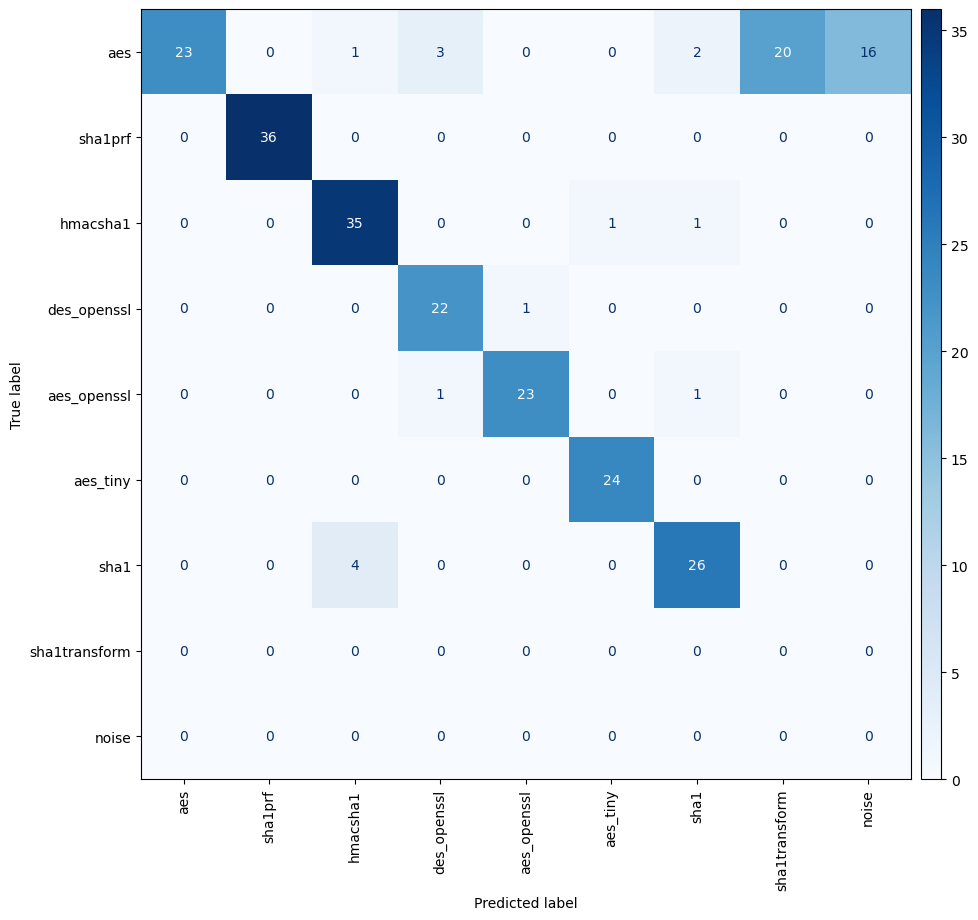

In [7]:
# test classification
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

test_datasets = ['nodemcu-random-label-test']
model_path = 'models/CNNBB-epoch-100.pt'

def test_model(datasets, model_path, model):
    print('test model: ' + model_path)
    datasets_root = "./datasets"

    model.load_state_dict(torch.load(model_path))
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    batch_c = []
    y_pred = []
    y_true = []

    for dataset_name in datasets:
        dataset_path = os.path.join(datasets_root, dataset_name)
        dataset_files = list(os.listdir(dataset_path))

        for i, dataset_file in enumerate(dataset_files):
            if '_traces.npy' in dataset_file:
                for batch in get_batch(dataset_path, dataset_file, batch_c, batch_size=20):
                    data, target, label = split_batch(batch)

                    if np.isnan(data).any():
                        print("nan in batch")
                        continue

                    x = torch.tensor(data).float().to(device)
                    y_out = model(x).detach().cpu().numpy()

                    y_true.extend(np.argmax(label[:, :-2], axis=1).tolist())
                    y_pred.extend(np.argmax(y_out[:, :-2], axis=1).tolist())

    assert len(y_true) == len(y_pred)
    report = classification_report(y_true, y_pred, output_dict=True)
    conf_matrix = confusion_matrix(y_true, y_pred)
    labels = ["aes", "sha1prf", "hmacsha1", "des_openssl", "aes_openssl", "aes_tiny", "sha1", "sha1transform", "noise"]
    cmp = ConfusionMatrixDisplay(conf_matrix, display_labels=labels)
    fig, ax = plt.subplots(figsize=(10, 10))
    cmp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation='vertical', colorbar=False)
    cax = fig.add_axes([ax.get_position().x1 + 0.01, ax.get_position().y0, 0.02, ax.get_position().height])
    plt.colorbar(cmp.im_, cax=cax)
    plt.show()

test_model(test_datasets, model_path, updated_model)